In [ ]:
# hide
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.optim import SGD
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from cf_step.step import Step
from cf_step.networks import SimpleCF
from cf_step.metrics import recall_at_k, precision_at_k
from cf_step.utils import moving_avg

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

%matplotlib inline

# CF STEP - Incremental Collaborative Filtering

> Incremental learning for recommender systems

CF STEP is an open-source library, written in python, that enables fast implementation of incremental learning recommender systems. The library is a by-product of the research project [CloudDBAppliance](https://clouddb.eu/).

## Install

Run `pip install cf-step` to install the library in your environment.

## How to use

For this example, we will use the popular [movielens](https://grouplens.org/datasets/movielens/) dataset. The dataset has collected and made available rating data sets from the [MovieLens](http://movielens.org) web site. The data sets were collected over various periods of time, depending on the size of the set.

First let us load the data in a pandas `DataFrame`. We assume that the reader has downloaded the 1m movielense dataset and have unziped it in the `/tmp` folder.

> To avoid creating a user and movie vocabularies we turn each user and movie to a categorical feature and use the pandas convenient cat attribute to get the codes

In [ ]:
# local

# load the data
col_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('/tmp/ratings.dat', delimiter='::', names=col_names, engine='python')

# transform users and movies to categorical features
ratings_df['user_id'] = ratings_df['user_id'].astype('category')
ratings_df['movie_id'] = ratings_df['movie_id'].astype('category')

# use the codes to avoid creating separate vocabularies
ratings_df['user_code'] = ratings_df['user_id'].cat.codes.astype(int)
ratings_df['movie_code'] = ratings_df['movie_id'].cat.codes.astype(int)

ratings_df.head()

,user_id,movie_id,rating,timestamp,user_code,movie_code
0,1,1193,5,978300760,0,1104
1,1,661,3,978302109,0,639
2,1,914,3,978301968,0,853
3,1,3408,4,978300275,0,3177
4,1,2355,5,978824291,0,2162


Using the codes we can see how many users and movies are in the dataset.

In [ ]:
# local
n_users = ratings_df['user_code'].max() + 1
n_movies = ratings_df['movie_code'].max() + 1

print(f'There are {n_users} unique users and {n_movies} unique movies in the movielens dataset.')

There are 6040 unique users and 3706 unique movies in the movielens dataset.


We will sort the data by Timestamp so as to simulate streaming events.

In [ ]:
# local
data_df = ratings_df.sort_values(by='timestamp')

The `Step` model supports only positive feedback. Thus, we will consider a rating of 5 as positive feedback and discard any other. We want to identify likes with `1` and dislikes with `0`.

In [ ]:
# local
# more than 4 -> 1, less than 5 -> 0
data_df['preference'] = np.where(data_df['rating'] > 4, 1, 0)
# keep only ones and discard the others
data_df_cleaned = data_df.loc[data_df['preference'] == 1]

data_df_cleaned.head()

,user_id,movie_id,rating,timestamp,user_code,movie_code,preference
999873,6040,593,5,956703954,6039,579,1
1000192,6040,2019,5,956703977,6039,1839,1
999920,6040,213,5,956704056,6039,207,1
999967,6040,3111,5,956704056,6039,2895,1
999971,6040,2503,5,956704191,6039,2309,1


Following, let us initialize our model.

In [ ]:
# local
net = SimpleCF(n_users, n_movies, factors=128, mean=0., std=.1)
objective = lambda pred, targ: targ - pred
optimizer = SGD(net.parameters(), lr=0.06)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Step(net, objective, optimizer, device=device)

Finally, let us get 20% of the data to fit the model for bootstrapping and create the Pytorch Dataset that we will use.

In [ ]:
# local
pct = int(data_df_cleaned.shape[0] * .2)
bootstrapping_data = data_df_cleaned[:pct]

We will create a dataset from our Dataframe. We extract four elements:

* The user code
* The movie code
* The rating
* The preference

In [ ]:
# local
features = ['user_code', 'movie_code', 'rating']
target = ['preference']

data_set = TensorDataset(torch.tensor(bootstrapping_data[features].values), 
                         torch.tensor(bootstrapping_data[target].values))

Create the Pytorch DataLoader that we will use. Batch size should always be `1` for online training.

In [ ]:
# local
data_loader = DataLoader(data_set, batch_size=512, shuffle=False)

Let us now use the *batch_fit()* method of the *Step* trainer to bootstrap our model. 

In [ ]:
# local
model.batch_fit(data_loader)

100%|██████████| 89/89 [00:01<00:00, 63.79it/s]


Then, to simulate streaming we get the remaining data and create a different data set.

In [ ]:
# local
data_df_step = data_df_cleaned.drop(bootstrapping_data.index)
data_df_step = data_df_step.reset_index(drop=True)
data_df_step.head()

# create the DataLoader
stream_data_set = TensorDataset(torch.tensor(data_df_step[features].values), 
                                torch.tensor(data_df_step[target].values))
stream_data_loader = DataLoader(stream_data_set, batch_size=1, shuffle=False)

Simulate the stream...

In [ ]:
# local
k = 10 # we keep only the top 10 recommendations
recalls = []
known_users = []

with tqdm(total=len(stream_data_loader)) as pbar:
    for idx, (features, preferences) in enumerate(stream_data_loader):
        itr = idx + 1
        
        user = features[:, 0]
        item = features[:, 1]
        rtng = features[:, 2]
        pref = preferences
        
        if user.item() in known_users:
            predictions = model.predict(user, k)
            recall = recall_at_k(predictions.tolist(), item.tolist(), k)
            recalls.append(recall)
            model.step(user, item, rtng, pref)
        else:
            model.step(user, item, rtng, pref)
            
        known_users.append(user.item())
        pbar.update(1)

100%|██████████| 181048/181048 [13:03<00:00, 231.12it/s]


Last but not least, we visualize the results of the recall@10 metric, using a moving average window of 5k elements. 

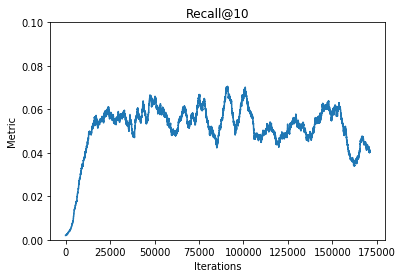

In [ ]:
# local
avgs = moving_avg(recalls, 5000)

plt.title('Recall@10')
plt.xlabel('Iterations')
plt.ylabel('Metric')
plt.ylim(0., .1)
plt.plot(avgs)
plt.show()

Finally, save the model's weights.

In [ ]:
# local
model.save(os.path.join('artefacts', 'positive_step.pt'))

## References

1. Vinagre, J., Jorge, A. M., & Gama, J. (2014, July). Fast incremental matrix factorization for recommendation with positive-only feedback. In International Conference on User Modeling, Adaptation, and Personalization (pp. 459-470). Springer, Cham.
2. Hu, Y., Koren, Y., & Volinsky, C. (2008, December). Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE International Conference on Data Mining (pp. 263-272). Ieee.